In [3]:
import MDAnalysis as mda
import mdtraj as md
import os

In [4]:
from os import walk
import socket
if socket.gethostname() == 'jim-Mint':
    ppi_path = '/home/jim/src/p39/fftanalysis/test_systems'
    home = '/home/jim'
elif socket.gethostname() == 'host252.ent.iit.edu':
    ppi_path = '/home/jtufts/Downloads/test_systems'
    home = '/home/jtufts'
elif socket.gethostname() == 'pandora':
    # ppi_path = '/home/jtufts/src/p39/fftanalysis/test_systems'
    ppi_path = '/mnt/fft/FFT_PPI'
    home = '/home/jtufts'
else:
    ppi_path = '/home/jtufts/src/p39/fftanalysis/test_systems'
    home = '/home/jtufts'

In [5]:
f = {}
for (dirpath, dirnames, filenames) in walk(f'{ppi_path}/2.redock/2.minimize'):
    if len(filenames) > 0:
        if filenames[0] != 'run_me.sh':
            if 'ligand.inpcrd' in filenames:
                # f[dirpath.split('/')[9]] = dirpath + '/ligand.inpcrd'
                f[dirpath.split('/')[6]] = dirpath + '/ligand.inpcrd'

In [6]:
keys = list(f.keys())
keys.sort()
system = keys[144] #36 #8
print(system, f[system])

2X9A_D:C /mnt/fft/FFT_PPI/2.redock/2.minimize/2X9A_D:C/ligand.inpcrd


In [97]:
# Define the file paths for the two PDB files you want to combine
# pdb_file1 = "/mnt/fft/structures/2OOB_r_b.pdb"
# pdb_file2 = "/mnt/fft/structures/2OOB_l_b.pdb"

for system in keys:
    pdb_file1 = f"{ppi_path}/2.redock/4.receptor_grid/{system}/native_pose.pdb"
    pdb_file2 = f"{ppi_path}/2.redock/4.receptor_grid/{system}/receptor_trans.pdb"
    
    # Load the PDB files into MDAnalysis Universes
    u1 = mda.Universe(pdb_file1)
    u1 = mda.Universe(pdb_file1)
    u1_chainid = np.empty((u1.atoms.chainIDs.shape), dtype='O')
    u1_chainid[:] = "L"
    u1.atoms.chainIDs = u1_chainid
    u2 = mda.Universe(pdb_file2)
    u2_chainid = np.empty((u2.atoms.chainIDs.shape), dtype='O')
    u2_chainid[:] = "R"
    u2.atoms.chainIDs = u2_chainid
    
    combined_universe = mda.Merge(u1.atoms,u2.atoms)
    if not os.path.exists(f"{ppi_path}/2.redock/7.analysis/{system}/dockq"):
        os.mkdir(f"{ppi_path}/2.redock/7.analysis/{system}/dockq")
    # Save the combined structure to a new PDB file
    combined_universe.atoms.write(f"{ppi_path}/2.redock/7.analysis/{system}/dockq/native_complex.pdb")


In [179]:
for system in keys[146:]:
    fft_sampling_nc = f"{ppi_path}/2.redock/5.fft_sampling/{system}/fft_sample.nc"

    pdb_file1 = f"{ppi_path}/2.redock/expanse_6.postprocess/{system}/ligand_resampled.pdb"
    pdb_file2 = f"{ppi_path}/2.redock/4.receptor_grid/{system}/receptor_trans.pdb"
    
    
    # Load the PDB files into MDAnalysis Universes
    u1 = mda.Universe(pdb_file1)
    u1_chainid = np.empty((u1.atoms.chainIDs.shape), dtype='O')
    u1_chainid[:] = "L"
    u1.atoms.chainIDs = u1_chainid
    u2 = mda.Universe(pdb_file2)
    u2_chainid = np.empty((u2.atoms.chainIDs.shape), dtype='O')
    u2_chainid[:] = "R"
    u2.atoms.chainIDs = u2_chainid

    for frame in u1.trajectory[:100]:
        combined_universe = mda.Merge(u1.atoms,u2.atoms)
        if not os.path.exists(f"{ppi_path}/2.redock/7.analysis/{system}/dockq"):
            os.mkdir(f"{ppi_path}/2.redock/7.analysis/{system}/dockq")
        # Save the combined structure to a new PDB file
        combined_universe.atoms.write(f"{ppi_path}/2.redock/7.analysis/{system}/dockq/docked_complex_no_native_{u1.trajectory.frame}.pdb")

In [209]:
for system in keys:
    try:
        fft_sampling_nc = f"{ppi_path}/2.redock/5.fft_sampling/{system}/fft_sample.nc"
    
        pdb_file1 = f"{ppi_path}/2.redock/6.postprocess/{system}/ligand_resampled.pdb"
        pdb_file2 = f"{ppi_path}/2.redock/4.receptor_grid/{system}/receptor_trans.pdb"
        
        
        # Load the PDB files into MDAnalysis Universes
        u1 = mda.Universe(pdb_file1)
        u1_chainid = np.empty((u1.atoms.chainIDs.shape), dtype='O')
        u1_chainid[:] = "L"
        u1.atoms.chainIDs = u1_chainid
        u2 = mda.Universe(pdb_file2)
        u2_chainid = np.empty((u2.atoms.chainIDs.shape), dtype='O')
        u2_chainid[:] = "R"
        u2.atoms.chainIDs = u2_chainid
    
        for frame in u1.trajectory[:100]:
            combined_universe = mda.Merge(u1.atoms,u2.atoms)
            if not os.path.exists(f"{ppi_path}/2.redock/7.analysis/{system}/dockq"):
                os.mkdir(f"{ppi_path}/2.redock/7.analysis/{system}/dockq")
            # Save the combined structure to a new PDB file
            combined_universe.atoms.write(f"{ppi_path}/2.redock/7.analysis/{system}/dockq/docked_complex_incl_native_{u1.trajectory.frame}.pdb")
    except:
        print(f"{system} failed")

In [198]:
import pickle as p
for system in keys:
    try:
        bpmf_pkl_file = f"{ppi_path}/2.redock/expanse_6.postprocess/{system}/bpmf.pkl"
        
        pdb_file1 = f"{ppi_path}/2.redock/6.postprocess/{system}/ligand_resampled.pdb"
        pdb_file2 = f"{ppi_path}/2.redock/4.receptor_grid/{system}/receptor_trans.pdb"
        
        bpmf_dict = p.load(open(bpmf_pkl_file, "rb"))
        lowest_energies = np.argsort(test2["energies"]["delta_E"]["OpenMM_OBC2"])[:10]
        # Load the PDB files into MDAnalysis Universes
        u1 = mda.Universe(pdb_file1)
        u1_chainid = np.empty((u1.atoms.chainIDs.shape), dtype='O')
        u1_chainid[:] = "L"
        u1.atoms.chainIDs = u1_chainid
        u2 = mda.Universe(pdb_file2)
        u2_chainid = np.empty((u2.atoms.chainIDs.shape), dtype='O')
        u2_chainid[:] = "R"
        u2.atoms.chainIDs = u2_chainid
        
        for i, index in enumerate(lowest_energies):
            u1.trajectory[index]
            combined_universe = mda.Merge(u1.atoms,u2.atoms)
            if not os.path.exists(f"{ppi_path}/2.redock/7.analysis/{system}/dockq"):
                os.mkdir(f"{ppi_path}/2.redock/7.analysis/{system}/dockq")
            # Save the combined structure to a new PDB file
            combined_universe.atoms.write(f"{ppi_path}/2.redock/7.analysis/{system}/dockq/docked_complex_incl_native_{i}.pdb")
    except:
        print(f"failed {system}")

failed 3A4S_A:D


In [ ]:
import subprocess
dockq_results = {}
for system in keys:
    try:
        system_results = {}
        for i in range(1):
            command = f"/home/jtufts/src/p39/DockQ/DockQ.py {ppi_path}/2.redock/7.analysis/{system}/dockq/native_complex.pdb {ppi_path}/2.redock/7.analysis/{system}/dockq/docked_complex_no_native_obc2_{i}.pdb"
            output = subprocess.check_output(command, shell=True, universal_newlines=True)
            
            data_dict = {}
            
            # Split the text into lines
            lines = output.strip().split('\n')
            
            # Iterate through the lines and extract values
            for line in lines:
                if "Number of equivalent residues in chain L" in line:
                    data_dict["chain_L"] = int(line.split()[-2])
                elif "Number of equivalent residues in chain R" in line:
                    data_dict["chain_R"] = int(line.split()[-2])
                elif line.startswith("Fnat"):
                    data = line.split()
                    data_dict["Fnat"] = float(data[1])
                elif line.startswith("Fnonnat"):
                    data = line.split()
                    data_dict["Fnonnat"] = float(data[1])
                elif line.startswith("iRMS"):
                    data = line.split()
                    data_dict["iRMSD"] = float(data[1])
                elif line.startswith("LRMS"):
                    data = line.split()
                    data_dict["LRMS"] = float(data[1])
                elif line.startswith("DockQ"):
                    data = line.split()
                    data_dict["DockQ"] = float(data[1])
            
            # Print the extracted data as a dictionary
            system_results[i] = data_dict
        dockq_results[system] = system_results
    except:
        print(f"failed to generate score for {system}")
print(dockq_results)

In [ ]:
import subprocess
from multiprocessing import Pool

def calculate_dockq(system):
    system_results = {}
    for i in range(100):
        try:
            command = f"/home/jtufts/src/p39/DockQ/DockQ.py {ppi_path}/2.redock/7.analysis/{system}/dockq/native_complex.pdb {ppi_path}/2.redock/7.analysis/{system}/dockq/docked_complex_incl_native_{i}.pdb"
            output = subprocess.check_output(command, shell=True, universal_newlines=True)

            data_dict = {}

            # Split the text into lines
            lines = output.strip().split('\n')

            # Iterate through the lines and extract values
            for line in lines:
                if "Number of equivalent residues in chain L" in line:
                    data_dict["chain_L"] = int(line.split()[-2])
                elif "Number of equivalent residues in chain R" in line:
                    data_dict["chain_R"] = int(line.split()[-2])
                elif line.startswith("Fnat"):
                    data = line.split()
                    data_dict["Fnat"] = float(data[1])
                elif line.startswith("Fnonnat"):
                    data = line.split()
                    data_dict["Fnonnat"] = float(data[1])
                elif line.startswith("iRMS"):
                    data = line.split()
                    data_dict["iRMSD"] = float(data[1])
                elif line.startswith("LRMS"):
                    data = line.split()
                    data_dict["LRMS"] = float(data[1])
                elif line.startswith("DockQ"):
                    data = line.split()
                    data_dict["DockQ"] = float(data[1])

            system_results[i] = data_dict
        except Exception as e:
            print(f"failed to generate score for {system} iteration {i}: {str(e)}")
    return (system, system_results)

if __name__ == '__main__':
    # Create a pool of worker processes
    pool = Pool(processes=20)  # You can adjust the number of processes as needed

    # Define your 'keys' list here
    keys = keys

    # Use the pool to parallelize the calculations
    results = pool.map(calculate_dockq, keys)

    # Close the pool and wait for all processes to complete
    pool.close()
    pool.join()

    # Convert the results to a dictionary
    dockq_results = dict(results)

print(dockq_results)

In [9]:
dockq_results.keys()

dict_keys(['1A2K_C:AB', '1ACB_E:I', '1AHW_AB:C', '1AK4_A:D', '1AKJ_AB:DE', '1ATN_A:D', '1AVX_A:B', '1AVZ_B:C', '1AY7_A:B', '1B6C_A:B', '1BJ1_HL:VW', '1BRS_A:D', '1BUH_A:B', '1BVK_DE:F', '1BVN_P:T', '1CBW_ABC:D', '1DE4_AB:CF', '1DFJ_E:I', '1DQJ_AB:C', '1E4K_AB:C', '1E6E_A:B', '1E6J_HL:P', '1E96_A:B', '1EAW_A:B', '1EER_A:BC', '1EFN_B:A', '1EMV_A:B', '1EWY_A:C', '1EZU_C:AB', '1F34_A:B', '1F6M_A:C', '1FC2_C:D', '1FFW_A:B', '1FLE_E:I', '1FQJ_A:B', '1FSK_BC:A', '1GCQ_B:C', '1GL1_A:I', '1GLA_G:F', '1GPW_A:B', '1GRN_A:B', '1GXD_A:C', '1H1V_A:G', '1H9D_A:B', '1HCF_AB:X', '1HE8_B:A', '1HIA_AB:I', '1I2M_A:B', '1I4D_D:AB', '1IB1_AB:E', '1IBR_A:B', '1IJK_A:BC', '1IQD_AB:C', '1J2J_A:B', '1JIW_P:I', '1JMO_A:HL', '1JPS_HL:T', '1JTD_B:A', '1JTG_B:A', '1JWH_CD:A', '1K5D_AB:C', '1KAC_A:B', '1KKL_ABC:H', '1KLU_AB:D', '1KTZ_A:B', '1KXP_A:D', '1KXQ_H:A', '1LFD_B:A', '1M10_A:B', '1M27_AB:C', '1MAH_A:F', '1MLC_AB:E', '1MQ8_A:B', '1NB5_AP:I', '1NCA_HL:N', '1NSN_HL:S', '1NVU_Q:S', '1NVU_R:S', '1NW9_B:A', '1OC0_

In [11]:
import numpy as np
dockq_keys = list(dockq_results.keys())
all_scores = []
for dockq_key in dockq_keys:
    system_max = 0.0
    system_scores = []
    for i in range(100):
        if i in dockq_results[dockq_key].keys():
            if dockq_results[dockq_key][i]["DockQ"] > system_max:
                system_max = dockq_results[dockq_key][i]["DockQ"]
            system_scores.append(dockq_results[dockq_key][i]["DockQ"])
        else:
            system_scores.append(0)
    all_scores.append(system_scores)
system_max_scores = []
for system_score_list in all_scores:
    if len(system_score_list) > 0:
        system_max_scores.append(np.max(system_score_list))
print(np.mean(all_scores), np.mean(system_max_scores))
print(all_scores)
            

0.4207837430167598 0.9559664804469273
[[0.03, 0.03, 0.03, 0.042, 0.03, 0.041, 0.042, 0.03, 0.041, 0.041, 0.031, 0.031, 0.042, 0.031, 0.031, 0.04, 0.04, 0.031, 0.03, 0.03, 0.087, 0.042, 0.042, 0.087, 0.043, 0.031, 0.087, 0.031, 0.042, 0.041, 0.028, 0.03, 0.03, 0.032, 0.031, 0.028, 0.042, 0.043, 0.03, 0.031, 0.043, 0.041, 0.018, 0.03, 0.03, 0.017, 0.041, 0.043, 0.032, 0.03, 0.03, 0.028, 0.019, 0.043, 0.031, 0.042, 0.031, 0.042, 0.087, 0.085, 0.028, 0.031, 0.031, 0.041, 0.022, 0.03, 0.03, 0.023, 0.031, 0.03, 0.017, 0.028, 0.017, 0.088, 0.035, 0.03, 0.031, 0.018, 0.03, 0.031, 0.028, 0.031, 0.086, 0.028, 0.023, 0.086, 0.041, 0.031, 0.017, 0.017, 0.019, 0.018, 0.018, 0.019, 0.031, 0.085, 0.088, 0.019, 0.086, 0.086], [1.0, 0.988, 0.986, 0.976, 0.979, 0.953, 0.015, 0.015, 0.014, 0.015, 0.015, 0.016, 0.012, 0.012, 0.015, 0.058, 0.012, 0.972, 0.014, 0.014, 0.015, 0.013, 0.016, 0.015, 0.012, 0.013, 0.014, 0.014, 0.012, 0.016, 0.013, 0.016, 0.013, 0.014, 0.016, 0.014, 0.016, 0.016, 0.013, 0.016, 0

In [16]:
count = 0
for s in all_scores:
    print(np.array(s[1:]).max())
    if np.array(s[1:]).max() > 0.8:
        count += 1
print(count/179)

0.088
0.988
0.989
0.994
0.981
0.992
0.988
0.986
0.991
0.988
0.007
0.991
0.985
0.992
0.984
0.993
0.987
0.985
0.99
0.991
0.988
0.99
0.991
0.987
0.983
0.992
0.991
0.988
0.988
0.987
0.986
0.992
0.994
0.989
0.991
0.993
0.993
0.988
0.018
0.988
0.991
0.989
0.99
0.993
0.988
0.992
0.988
0.991
0.991
0.981
0.986
0.992
0.987
0.993
0.987
0.985
0.986
0.984
0.99
0.99
0.99
0.992
0.991
0.99
0.993
0
0.987
0.992
0.99
0.992
0.991
0.993
0.99
0.989
0.986
0.993
0.991
0.981
0.989
0.991
0.007
0.992
0.993
0.993
0.992
0.992
0.987
0.99
0.992
0.992
0.98
0.991
0.99
0.989
0.987
0.987
0.993
0.989
0.985
0.983
0.992
0.985
0.987
0.991
0.987
0.991
0.991
0.98
0.991
0.992
0.99
0.994
0.988
0.988
0.01
0.987
0.987
0.983
0.654
0.986
0.986
0.985
0.992
0.992
0.991
0.982
0.991
0.99
0.991
0.985
0.983
0.993
0.992
0.983
0.994
0.982
0.993
0.985
0.993
0.987
0.981
0.99
0.994
0.991
0.986
0.008
0.992
0.989
0.991
0.988
0.992
0.99
0.991
0.99
0.988
0.993
0.986
0.991
0.991
0.119
0.99
0.99
0.991
0.99
0.984
0.993
0.992
0.987
0.993
0.991
0.987


In [212]:
import pickle as p
p.dump(all_scores, open("top_100_all_scores_with_native.p", "wb"))
p.dump(dockq_results, open("top_100_dockq_results_with_native.p", "wb"))

In [28]:
import pickle as p
all_scores_without_native = p.load(open("top_100_all_scores_without_native.p", "rb"))
all_scores_with_native = p.load(open("top_100_all_scores_with_native.p", "rb"))

In [45]:
count1 = 0
for val in all_scores_without_native:
    if np.max(val)>0.23:
        count1 += 1
print(count1/179)

count2 = 0
for val in all_scores_with_native:
    if np.max(val)>0.23:
        count2 += 1
print(count2/179)

0.7150837988826816
0.9608938547486033


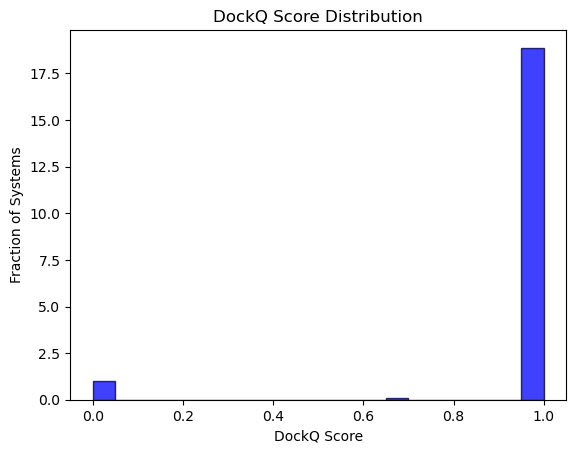

In [58]:
import matplotlib.pyplot as plt

def plot_dockq_histogram(dockq_scores):
    # Create a histogram
    plt.hist(dockq_scores, bins=20, density=True, alpha=0.75, color='blue', edgecolor='black')

    # Set labels and title
    plt.xlabel('DockQ Score')
    plt.ylabel('Fraction of Systems')
    plt.title('DockQ Score Distribution')

    # Display the plot
    plt.show()

if __name__ == "__main__":
    # Example data (replace this with your actual DockQ scores)
    # dockq_scores = [0.2, 0.5, 0.7, 0.8, 0.6, 0.4, 0.9, 0.3, 0.1, 0.5, 0.7]

    # Call the function to plot the histogram
    plot_dockq_histogram(np.array(all_scores_with_native)[:,0])


In [221]:
test = f"{ppi_path}/2.redock/expanse_6.postprocess/2OOB_A:B/bpmf.pkl"
test2 = p.load(open(test, "rb"))


In [233]:
test3 = np.argsort(test2["energies"]["inter_energies"]["OpenMM_OBC2"] - test2["energies"]["delta_E"]["OpenMM_OBC2"])[:100]
# test3 = np.argsort(test2["energies"]["delta_E"]["OpenMM_OBC2"])[:10]
print(test3, (test2["energies"]["inter_energies"]["OpenMM_OBC2"] - test2["energies"]["delta_E"]["OpenMM_OBC2"])[:100])

[  0   4   5  22   1   2   7  19   3  25   9   6   8  28  61  10  16  95
  11  77  48  12  13  38  15  14  53  18  83  17  20  40  23  26  30  44
  24  27 834  66  42  31  29  32  36  46  33  39  52  37  35  21  58  41
 783 124  43  57  92  45  49  47 103  75  50  51  81 221  54 356  74  55
  63  59  69  56 117 108  65  70  71  60  78  93  62  67  72  64 170  76
  94 100  89  73 510  79  97 393 122 145] [678.58536613 701.92950451 709.20657565 719.77511054 687.36182481
 690.80360077 733.6929934  714.3872117  736.65302342 725.01082995
 741.79631483 749.9309124  754.42253973 756.34112094 760.36874104
 758.93470662 748.1276328  764.48598829 761.51848933 715.26014281
 766.81862826 791.84607657 700.81103236 773.72318654 776.65987617
 720.33668066 775.68611451 778.67321941 739.57897646 783.45053328
 776.02081591 783.35810528 786.84796248 787.66907789 838.13429882
 790.5012025  786.87410373 790.41250896 758.10192101 788.05232732
 772.45160134 792.92953812 782.82874492 795.8928358  776.57351667

In [ ]:
for f1 in test3:
        u1.trajectory[f1
        combined_universe = mda.Merge(u1.atoms,u2.atoms)
        if not os.path.exists(f"{ppi_path}/2.redock/7.analysis/{system}/dockq"):
            os.mkdir(f"{ppi_path}/2.redock/7.analysis/{system}/dockq")
        # Save the combined structure to a new PDB file
        combined_universe.atoms.write(f"{ppi_path}/2.redock/7.analysis/{system}/dockq/docked_complex_no_native_{u1.trajectory.frame}.pdb")

In [ ]:
test2["energies"]["delta_E"]["OpenMM_OBC2"]

In [175]:
a = p.load(open("all_scores_without_native.p", "rb"))
b = p.load(open("dockq_results_without_native.p", "rb"))



In [235]:
test2["energies"].keys()

dict_keys(['lig_desol_fe', 'rec_desol_fe', 'complex_sol_fe', 'delta_E', 'lse', 'inter_energies'])

In [239]:
print(np.argsort(test2["energies"]["lse"]["OpenMM_OBC2"])[:100])

[ 22  25   4  95   5   9   0  61  19 834  21   2   7   1  28  38   6   3
  34  83  40  77  48  16  53 783   8  10  66  11  15  12 122  30 170  18
 510  17  13 356  44  14  27 124 108  20 103  42  31  26  81  23 221  24
 393  39  29  58  52  92  33  46  93  41  49  36 157  57  32  65  75  37
  35  45 530  43  51 207  47 553 145  97 217  50  72 241 118  69 100 186
  59 371 159 818  63 189  54  56 177  62]
